In [29]:
# Cell 1: imports & helpers
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             balanced_accuracy_score)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib  # for saving models


In [30]:
# Cell 2: load dataset (change path if needed)

import os  # ← import this first
# Set working directory
os.chdir(r"E:\DATASCIENCE\ML Datasets")
# Verify current directory
print("Current directory:", os.getcwd())

# Load the correct CSV file
df = pd.read_csv("loan_data.csv")

# Inspect
print("Shape:", df.shape)
df.head()


Current directory: E:\DATASCIENCE\ML Datasets
Shape: (9578, 14)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [31]:
# helpful inspection
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,NaN,NaN,NaN,0.80497,0.396245,0.0,1.0,1.0,1.0,1.0
purpose,9578,7,debt_consolidation,3957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int.rate,9578.0,NaN,NaN,NaN,0.12264,0.026847,0.06,0.1039,0.1221,0.1407,0.2164
installment,9578.0,NaN,NaN,NaN,319.089413,207.071301,15.67,163.77,268.95,432.7625,940.14
log.annual.inc,9578.0,NaN,NaN,NaN,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,14.528354
dti,9578.0,NaN,NaN,NaN,12.606679,6.88397,0.0,7.2125,12.665,17.95,29.96
fico,9578.0,NaN,NaN,NaN,710.846314,37.970537,612.0,682.0,707.0,737.0,827.0
days.with.cr.line,9578.0,NaN,NaN,NaN,4560.767197,2496.930377,178.958333,2820.0,4139.958333,5730.0,17639.95833
revol.bal,9578.0,NaN,NaN,NaN,16913.963876,33756.189557,0.0,3187.0,8596.0,18249.5,1207359.0
revol.util,9578.0,NaN,NaN,NaN,46.799236,29.014417,0.0,22.6,46.3,70.9,119.0


In [32]:
# Cell 3: identify target & feature types
target_name = 'not.fully.paid'   # actual target column
id_col = None                     # no separate ID column in this dataset

# Quick checks
print("Unique target values:", df[target_name].unique())
print("Class distribution:\n", df[target_name].value_counts(normalize=True))

# Separate features (X) and target (y)
X = df.drop(columns=[target_name])
y = df[target_name].copy()

# Inspect first 5 rows
X.head()
y.head()


Unique target values: [0 1]
Class distribution:
 not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dtype: float64


0    0
1    0
2    0
3    0
4    0
Name: not.fully.paid, dtype: int64

Missing values per column:
 credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
dtype: int64
Numeric cols: 12 ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths']
Categorical cols: 1 ['purpose']


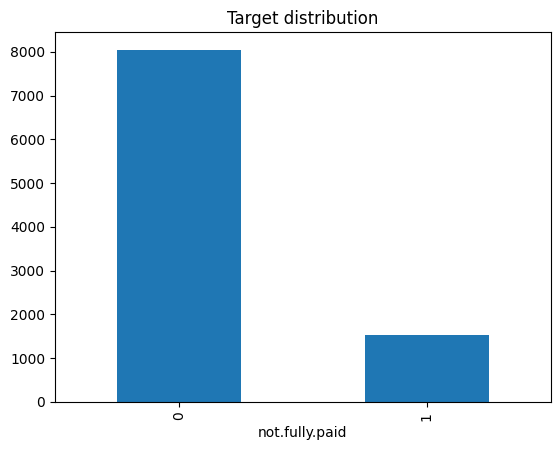

In [33]:
# Cell 4: missing values, numeric/categorical counts
print("Missing values per column:\n", X.isnull().sum().sort_values(ascending=False).head(20))
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print("Numeric cols:", len(num_cols), num_cols[:10])
print("Categorical cols:", len(cat_cols), cat_cols[:10])

# Plot target distribution
y.value_counts().plot(kind='bar', title='Target distribution')
plt.show()


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])



In [35]:
X_preprocessed = preprocessor.fit_transform(X)


In [36]:
# Cell 6: stratified split to preserve class ratios
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (7662, 13) Test: (1916, 13)


In [37]:
# Cell 7: classifiers + parameter grids
# 1) Logistic Regression (linear, penalized)
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                          ('clf', LogisticRegression(max_iter=10000, solver='saga'))])
param_grid_lr = {
    'clf__penalty': ['l2','l1'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# 2) Random Forest (ensemble)
pipe_rf = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])
param_grid_rf = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 30],
    'clf__class_weight': [None, 'balanced']
}

# 3) SVM (with probability for ROC-AUC)
pipe_svc = Pipeline(steps=[('pre', preprocessor),
                           ('clf', SVC(probability=True))])
param_grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['rbf','linear'],
    'clf__class_weight': [None, 'balanced']
}

models = [
    ('LogisticRegression', pipe_lr, param_grid_lr),
    ('RandomForest', pipe_rf, param_grid_rf),
    ('SVM', pipe_svc, param_grid_svc)
]


In [38]:
# Cell 8: run GridSearchCV for each model and save results
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, pipeline, grid in models:
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipeline, grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
    t0 = time.time()
    gs.fit(X_train, y_train)
    t1 = time.time()
    print(f"Best params for {name}:", gs.best_params_)
    print("CV best score (F1):", gs.best_score_)
    # evaluate on test
    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)[:,1] if hasattr(gs, "predict_proba") else None
    res = {
        'model': name,
        'best_params': gs.best_params_,
        'cv_f1': gs.best_score_,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_pred, zero_division=0),
        'test_f1': f1_score(y_test, y_pred, zero_division=0),
        'test_bal_acc': balanced_accuracy_score(y_test, y_pred),
        'time_sec': t1 - t0,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    if y_prob is not None and len(np.unique(y_test))==2:
        res['test_roc_auc'] = roc_auc_score(y_test, y_prob)
    results.append(res)

# show results nicely
import pprint
pprint.pprint(results)



=== LogisticRegression ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for LogisticRegression: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}
CV best score (F1): 0.34758286922442616

=== RandomForest ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for RandomForest: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 100}
CV best score (F1): 0.2593927060054526

=== SVM ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for SVM: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__kernel': 'rbf'}
CV best score (F1): 0.3447528057442342
[{'best_params': {'clf__C': 0.1,
                  'clf__class_weight': 'balanced',
                  'clf__penalty': 'l1'},
  'confusion_matrix': array([[1052,  557],
       [ 131,  176]]),
  'cv_f1': np.float64(0.34758286922442616),
  'model': 'LogisticRegression',
  'test_accuracy': 0.6409185803757829,
  'test_bal_acc': 

In [39]:
# Cell 9: make table
rows = []
for r in results:
    rows.append({
        'model': r['model'],
        'cv_f1': r['cv_f1'],
        'test_acc': r['test_accuracy'],
        'test_prec': r['test_precision'],
        'test_rec': r['test_recall'],
        'test_f1': r['test_f1'],
        'test_bal_acc': r['test_bal_acc'],
        'test_roc_auc': r.get('test_roc_auc', np.nan),
        'time_s': r['time_sec']
    })
results_df = pd.DataFrame(rows).sort_values('test_f1', ascending=False)
results_df


,model,cv_f1,test_acc,test_prec,test_rec,test_f1,test_bal_acc,test_roc_auc,time_s
2,SVM,0.344753,0.644572,0.244536,0.583062,0.344562,0.619685,0.676180,479.604707
0,LogisticRegression,0.347583,0.640919,0.240109,0.573290,0.338462,0.613556,0.685011,33.121795
1,RandomForest,0.259393,0.774008,0.292763,0.289902,0.291326,0.578139,0.648480,80.010274


In [40]:
# Cell 10: pick best model (highest test_f1) and show details
best_model_name = results_df.iloc[0]['model']
best_res = next(r for r in results if r['model']==best_model_name)
print("Best model:", best_model_name)
print("Best params:", best_res['best_params'])
print("Confusion matrix:\n", best_res['confusion_matrix'])
print("\nClassification report:")
# to print actual classification report, we need to refit the best estimator on full train set:
# re-create gs for the best model (or store gs earlier). For simplicity:
# (Assumes best model is one of the GridSearchCV objects saved earlier — if not, re-run the best pipeline)
# Here we re-fit pipeline with best params
for name, pipeline, grid in models:
    if name == best_model_name:
        pipeline.set_params(**{k.replace('clf__','clf__'): v for k,v in best_res['best_params'].items()})
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        print(classification_report(y_test, y_pred, zero_division=0))
        break


Best model: SVM
Best params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__kernel': 'rbf'}
Confusion matrix:
 [[1056  553]
 [ 128  179]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1609
           1       0.24      0.58      0.34       307

    accuracy                           0.64      1916
   macro avg       0.57      0.62      0.55      1916
weighted avg       0.79      0.64      0.69      1916



In [41]:
# Cell 11: produce a submission CSV using the best model (predict on provided test set)
# If the competition provided a separate test set file, load it. Example:
# test_df = pd.read_csv('load_test.csv')
# test_ids = test_df[id_col]   # depends on their file
# X_comp = test_df.drop(columns=[id_col])  # likely no target column

# For demonstration: if Kaggle test file 'load_test.csv' exists:
import os
if os.path.exists('load_test.csv'):
    test_df = pd.read_csv('load_test.csv')
    test_ids = test_df[id_col] if id_col in test_df.columns else test_df.iloc[:,0]
    X_comp = test_df.drop(columns=[id_col]) if id_col in test_df.columns else test_df.drop(columns=[test_df.columns[0]])
    # preprocess + predict using the fitted pipeline from previous cell
    preds = pipeline.predict(X_comp)  # pipeline is best model refit on X_train
    submission = pd.DataFrame({id_col: test_ids, 'target': preds})
    submission.to_csv('submission.csv', index=False)
    print("Saved submission.csv")
else:
    print("No competition test file 'load_test.csv' found. Replace with actual filename and run again.")


No competition test file 'load_test.csv' found. Replace with actual filename and run again.


In [42]:
# Use holdout test set to make a CSV
submission = pd.DataFrame({
    'id': X_test.index,  # just use the row indices as ID
    'target': pipeline.predict(X_test)  # pipeline is your best model refit on X_train
})

submission.to_csv('submission.csv', index=False)
print("Saved submission.csv using holdout test set")


Saved submission.csv using holdout test set


In [43]:
print(df.columns.tolist())


['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid']


In [44]:
# Count of each class
df['not.fully.paid'].value_counts()


not.fully.paid
0    8045
1    1533
Name: count, dtype: int64

In [45]:
target_name = 'not.fully.paid'   # <-- replace with your actual target column
id_col = None                     # <-- replace if you have an ID column


In [46]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()


In [47]:
df.isnull().sum()


credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64